# CQF - Final Project

## Optimal Hedging with Advanced Greeks

### Imports

In [1]:
import pandas as pd
import numpy as np
import math
from functools import reduce
from itertools import accumulate
from scipy.stats import norm
from statistics import mean
from scipy.stats.mstats import gmean
from scipy.stats import qmc
import matplotlib.pyplot as plt
%matplotlib inline

### Equity prices evolution using Monte-Carlo

In order to generate equity prices paths we will use Monte-Carlo through the Geometric Brownian Motion (GBM). This means that the stock price follows a random walk and is consistent with the weak form of the efficient market hypothesis (EMH) - past price information is already incorporated, and the next price movement is "conditionally independent" of past price movements.

The formula for GBM is found below:

$$
\Delta S = S \mu \delta t + S \sigma \epsilon \sqrt{\Delta t}
$$

**where:**

$$
\begin{align*}
S &= \text{the stock price} \\
\Delta S &= \text{the change in stock price} \\
\mu &= \text{the expected return} \\
\sigma &= \text{the standard deviation of returns} \\
\epsilon &= \text{the random variable} \\
\Delta t &= \text{the elapsed time period} \\
\end{align*}
$$

We can use different ways for implement equity prices evolution computationally and we will discuss some of them as follow

#### Euler-Maruyama scheme

The Euler-Maruyama is a method for the approximate numerical solution of a stochastic differential equation (SDE).

$$
S_{n+1} = S_{n} + S_{n}r\Delta t + S_{n}\sigma \Delta B
$$

where:
$$
\begin{align*}
S_0 &= \alpha \\
\end{align*}
$$

In [2]:
def euler_maruyama_scheme(S0, r, dt, sigma, dB):
    """ the function returns the asset price evolution according to euler-maruyama scheme
    
    Keyword arguments:
    S0 -- the price of equity on time t0
    r -- the expected return
    dt -- the slice of time
    sigma -- the standard deviation of returns
    dB -- an array of random variables according to wiener process
    """
    return list(accumulate(dB, lambda S,db: S + r*S*dt + sigma*S*db, initial=S0))

<AxesSubplot:>

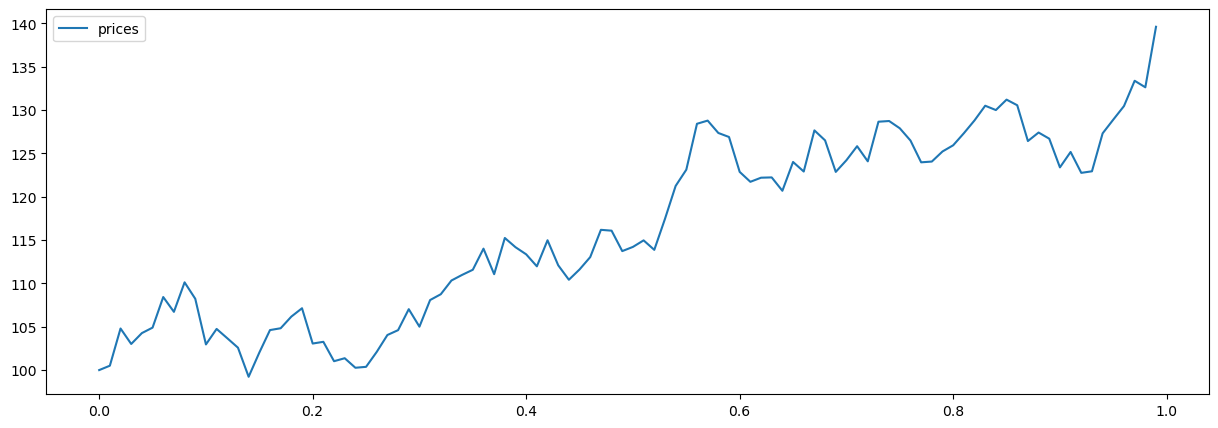

In [3]:
S0 = 100.0
T = 1.0
sigma = 0.2
r = 0.05
N = 100
dt = T / N
dB = np.random.randn(N-1)*np.sqrt(dt)

S = euler_maruyama_scheme(S0, r, dt, sigma, dB)
df = pd.DataFrame(index=np.arange(0, T, dt), data=S, columns=['prices'])
df.plot(colormap='tab10', figsize=[15,5])

#### Milstein scheme

The Milstein scheme is obtained by using the second order stochastic Taylor expansion, after rewriting it in Itô form

$$
S_{n+1} = S_{n} + rS_{n}\Delta t + \sigma S_{n}\Delta B + \frac{1}{2}\sigma^{2} S_{n} (\Delta B^{2} - \Delta t)
$$

In [4]:
def milstein_scheme(S0, r, dt, sigma, dB):
    """ the function returns the asset price evolution according to milstein scheme
    
    Keyword arguments:
    S0 -- the price of equity on time t0
    r -- the expected return
    dt -- the slice of time
    sigma -- the standard deviation of returns
    dB -- an array of random variables according to wiener process
    """
    return list(accumulate(dB, lambda S,db: S + r*S*dt + sigma*S*db + 0.5*(sigma**2)*S*(db**2-dt), initial=S0))

<AxesSubplot:>

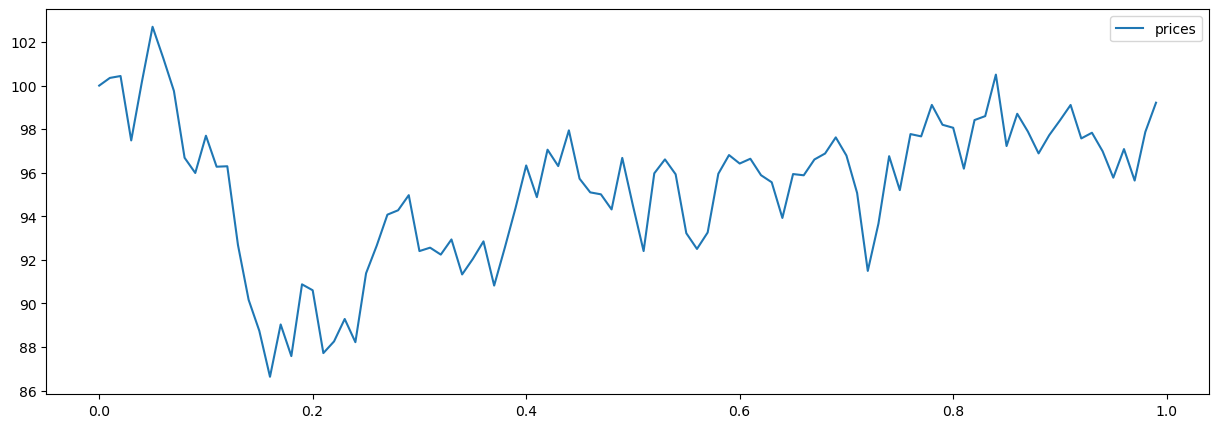

In [5]:
S0 = 100.0
T = 1.0
sigma = 0.2
r = 0.05
N = 100
dt = T / N
dB = np.random.randn(N-1)*np.sqrt(dt)

S = milstein_scheme(S0, r, dt, sigma, dB)
df = pd.DataFrame(index=np.arange(0, T, dt), data=S, columns=['prices'])
df.plot(colormap='tab10', figsize=[15,5])

#### Closed Form

$$
S_{n+1} = S_{n}\exp{((r-\frac{\sigma^2}{2})t + \sigma B(t))}
$$m

In [6]:
def closed_form_scheme(S0, r, dt, sigma, dB):
    """ the function returns the asset price evolution according to milstein scheme
    
    Keyword arguments:
    S0 -- the price of equity on time t0
    r -- the expected return
    dt -- the slice of time
    sigma -- the standard deviation of returns
    dB -- an array of random variables according to wiener process
    """
    return list(accumulate(dB, lambda S,db: S * np.exp((r-0.5*sigma**2)*dt + sigma*db), initial=S0))

<AxesSubplot:>

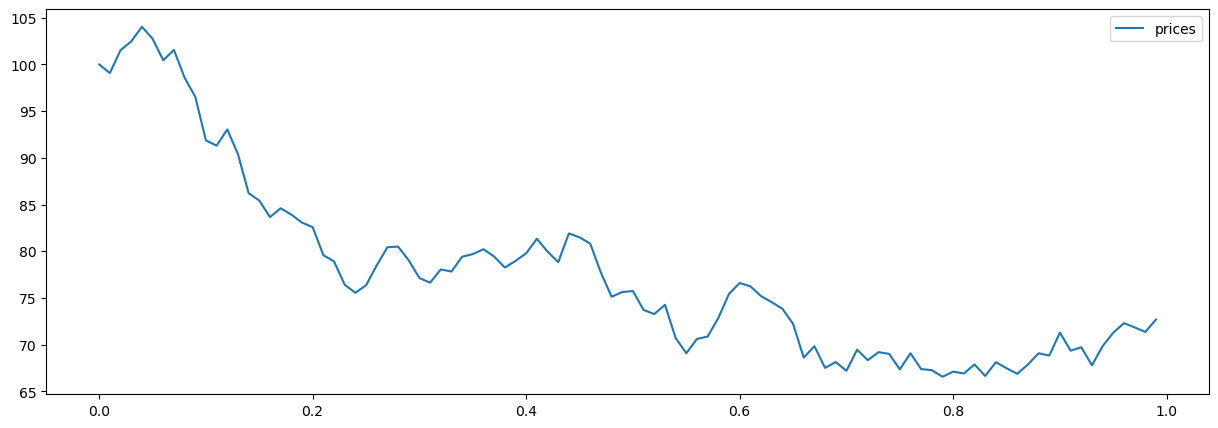

In [7]:
S0 = 100.0
T = 1.0
sigma = 0.2
r = 0.05
N = 100
dt = T / N
dB = np.random.randn(N-1)*np.sqrt(dt)

S = closed_form_scheme(S0, r, dt, sigma, dB)
df = pd.DataFrame(index=np.arange(0, T, dt), data=S, columns=['prices'])
df.plot(colormap='tab10', figsize=[15,5])

#### Schemes Comparison

<AxesSubplot:>

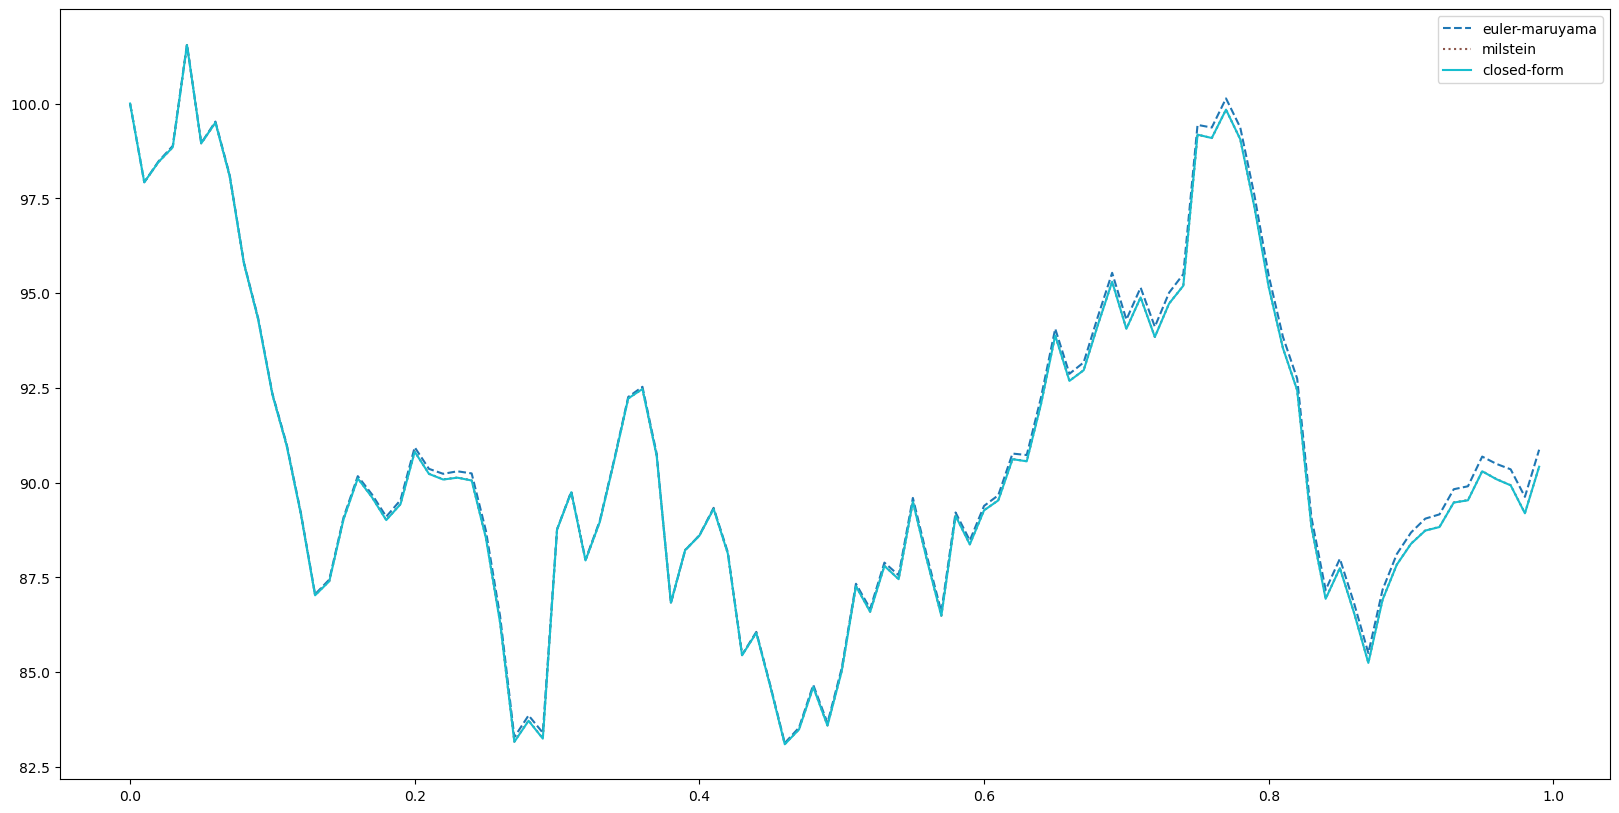

In [8]:
S0 = 100.0
T = 1.0
sigma = 0.2
r = 0.05
N = 100
dt = T / N
dB = np.random.randn(N-1)*np.sqrt(dt)

df_schemes = pd.DataFrame(index=np.arange(0, T, dt))
df_schemes['euler-maruyama'] = euler_maruyama_scheme(S0, r, dt, sigma, dB)
df_schemes['milstein'] = milstein_scheme(S0, r, dt, sigma, dB)
df_schemes['closed-form'] = closed_form_scheme(S0, r, dt, sigma, dB)
df_schemes.plot(style=['--', ':', '-'],colormap='tab10', figsize=[20,10])

### Improvements in Monte Carlo method

Some techniques can be used to improve the generation of a random variable

#### Variance Reduction with Antithetic Variables

In order to get a realistic comparison we will fixed the seed value for random number generator 

In [9]:
print('%15s %15s' % ('Mean', 'Std. Deviation'))
print(31* '-')
for i in range(1, 31, 2):
    np.random.seed(100)
    sn = np.random.standard_normal(i ** 2 * 10000)
    print('%15.12f %15.12f' % (sn.mean(), sn.std()))

           Mean  Std. Deviation
-------------------------------
 0.001150944833  1.006296354600
 0.002841204001  0.995987967146
 0.001998082016  0.997701714233
 0.001322322067  0.997771186968
 0.000592711311  0.998388962646
-0.000339730751  0.998399891450
-0.000228109010  0.998657429396
 0.000295768719  0.998877333340
 0.000257107789  0.999284894532
-0.000357870642  0.999456401088
-0.000528443742  0.999617831131
-0.000300171536  0.999445228838
-0.000162924037  0.999516059328
 0.000135778889  0.999611052522
 0.000182006048  0.999619405229


The result shows that the statistics get better the larger the sample size. However it does not still match.

The *antithetic variates* technic consists in draws only half the desired number of random draws, and adds the same set of random numbers with the opposite sign afterward. The described method works for sysmmetric median 0 random variables only, like standard normally distributed random variables, which are almost exclusively used throughout. 

In [10]:
print('%15s %15s' % ('Mean', 'Std. Deviation'))
print(31* '-')
for i in range(1, 31, 2):
    np.random.seed(100)
    sn = np.random.standard_normal(i ** 2 * int(10000 / 2))
    sn = np.concatenate((sn, -sn))
    print('%15.12f %15.12f' % (sn.mean(), sn.std()))

           Mean  Std. Deviation
-------------------------------
-0.000000000000  1.017474904235
 0.000000000000  0.998944776883
 0.000000000000  0.998018870658
 0.000000000000  0.997916558845
-0.000000000000  0.998119811838
 0.000000000000  0.998365584578
 0.000000000000  0.998171301115
-0.000000000000  0.998359568664
-0.000000000000  0.998772594780
-0.000000000000  0.998640403762
 0.000000000000  0.998868127277
 0.000000000000  0.999102053335
 0.000000000000  0.999342143561
 0.000000000000  0.999449673443
-0.000000000000  0.999613960655


This results in a mean value of zero, even in smaller sample sizes.

#### Quasi-MonteCarlo using Sobol low-discrepancy sequence

Quasi-Monte Carlo simulation is the traditional Monte Carlo simulation but using **quasi-random sequences** instead (pseudo) random numbers. These sequences are known as **low-discrepancy sequences** and they are **totally deterministic**, used in several cases to improve the performance of Monte Carlo simulations, offering shorter computational times and/or higher accuracy.

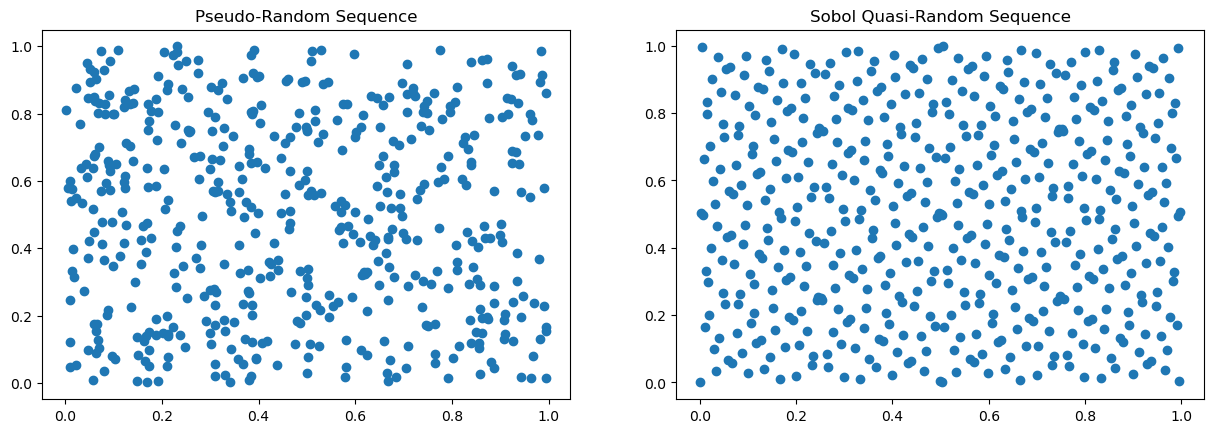

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
ax1.set_title('Pseudo-Random Sequence')
ax1.scatter(x=np.random.rand(2**9), y=np.random.rand(2**9))
sampler = qmc.Sobol(d=2, scramble=False)
sample_sequence = sampler.random_base2(m=9)
ax2.set_title('Sobol Quasi-Random Sequence')
ax2.scatter(x=sample_sequence[:,0], y=sample_sequence[:,1])

From the figure above we can see that quasi random sequence the points distribution is more homegenous than pseudo random. It is also possible to observe some small empty clusters in the pseudo-random sequence. 

Define the Black Scholes Merton close formula to solve an European Call

In [12]:
def BlackScholesMerton(S0, K, r, div, sigma, T):
    h1 = (np.log(S0 / K) + ((r - div) + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    h2 = h1 - sigma * np.sqrt(T)
    return S0 * np.exp(-div * T) * norm.cdf(h1) - K * np.exp(-r * T) * norm.cdf(h2)

Defining the parameters

In [13]:
S0 = 20.0 # pot at time zero
K = 20.0 # option strike
T = 2.0 # time to expiry
r = 0.08 # risk free rate
div = 0.08 # dividend yield
sigma = 0.25 # volatility

The exact solution

In [14]:
exact_soluction = BlackScholesMerton(S0=S0, K=K, r=r, div=div, sigma=sigma, T=T)
exact_soluction

2.3913916482553503

In [15]:
n_simul = 20000
trend = (r-div-0.5*sigma**2)*T

mc = np.exp(-r*T)*np.mean([max(s-K,0) for s in S0 * np.exp(trend + np.random.randn(n_simul)*np.sqrt(T)*sigma)])
qmc = np.exp(-r*T)*np.mean([max(S0 * np.exp(trend + sigma*np.sqrt(T)*norm.ppf(sobol_sequence(i))) - K, 0) for i in range(1, n_simul + 1)])

[exact_soluction, mc, qmc]

NameError: name 'sobol_sequence' is not defined

In [30]:
4 >> 1

2

In [602]:
class BrownianBridge:

    def __init__(self, steps):
        self.steps = steps
        self.map = np.zeros(steps)
        self.left_index = np.zeros(steps)
        self.right_index = np.zeros(steps)
        self.bridge_index = np.zeros(steps)
        self.left_weight = np.zeros(steps)
        self.right_weight = np.zeros(steps)
        self.stdev = np.zeros(steps)

        j = 0
        k = 0
        l = 0
        self.map[steps-1] = 1
        self.bridge_index[0] = steps-1
        self.stdev[0] = np.sqrt(steps)
        self.left_weight[0] = 0
        self.right_weight[0] = 0
        for i in range(1, steps):
            while self.map[j]: 
                j = j+1
            k=j
            while not self.map[k]:
                k=k+1
            l = j+((k-l-j)>>1)
            self.map[l] = i
            self.bridge_index[i] = l
            self.left_index[i] = j
            self.right_index[i] = k
            self.left_weight[i] = (k-l)/(k+1.-j)
            self.right_weight[i] = (l+1.-j)/(k+1.-j)
            self.stdev[i] = np.sqrt(((l+1.-j)*(k-l))/(k+1.-j))
            j=k+1
            if j>=steps:
                j =0 

    def build_path(self, B):
        path = np.zeros(self.steps)
        path[self.steps-1] = self.stdev[0]*B[0]
        for i in range(1, self.steps):
            j = int(self.left_index[i])
            k = int(self.right_index[i])
            l = int(self.bridge_index[i])
            if j:
                path[l] = self.left_weight[i]*path[j-1] + self.right_weight[i]*path[k] + self.stdev[i]*B[i]
            else:
                path[l] = self.right_weight[i]*path[k] + self.stdev[i]*B[i]
        
        return path

bb = BrownianBridge(100)


C:\Users\fbris\AppData\Local\Temp\ipykernel_19900\2511174509.py:34: RuntimeWarning: invalid value encountered in sqrt
  self.stdev[i] = np.sqrt(((l+1.-j)*(k-l))/(k+1.-j))


In [604]:
bb.build_path(np.random.randn(2**K))

array([ 1.85200387,  0.        ,         nan,  0.        ,         nan,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,         nan,  0.        ,  0.        ,         nan,
               nan,  0.        ,         nan,  0.        ,  0.        ,
               nan,         nan,  0.        ,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,  0.        ,         nan,         nan,         nan,
               nan,         nan,  0.        ,         nan,  0.        ,
               nan,  0.        ,         nan,         nan,  0.        ,
               nan,         nan,         nan,  0.        ,         nan,
               nan,  0.        ,  0.        ,         nan,         nan,
        0.        ,         nan,  0.        ,         nan,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
               nan,         nan,  0.        ,  2.32662739,  0.  

In [499]:
def brownian_bridge(T, K, B):
    N = 2**K
    Z = B[N-1] #np.random.normal()
    W = np.zeros(N+1)
    W[N] = Z * np.sqrt(T)
    h = N
    dt = T / N
    for k in range(1, K+1):
        h = h / 2
        for j in range(1, 2**(k-1)+1):
            Z = B[int((2*j-1)*h)-1]
            W[int((2*j-1)*h)] = 0.5*(W[int(2*(j-1)*h)] + W[int(2*j*h)]) + Z * np.sqrt(h*dt)
    return W

(array([ 12.,  32.,  31.,  28.,  42.,  67.,  79., 136., 157., 122., 160.,
        235., 242., 172., 189., 178., 228., 181., 204., 216., 242., 238.,
        197., 232., 196., 110.,  78.,  57.,  20.,  16.]),
 array([-0.61632723, -0.57066067, -0.52499412, -0.47932756, -0.433661  ,
        -0.38799445, -0.34232789, -0.29666134, -0.25099478, -0.20532823,
        -0.15966167, -0.11399512, -0.06832856, -0.02266201,  0.02300455,
         0.0686711 ,  0.11433766,  0.16000421,  0.20567077,  0.25133732,
         0.29700388,  0.34267043,  0.38833699,  0.43400354,  0.4796701 ,
         0.52533665,  0.57100321,  0.61666976,  0.66233632,  0.70800287,
         0.75366943]),
 <BarContainer object of 30 artists>)

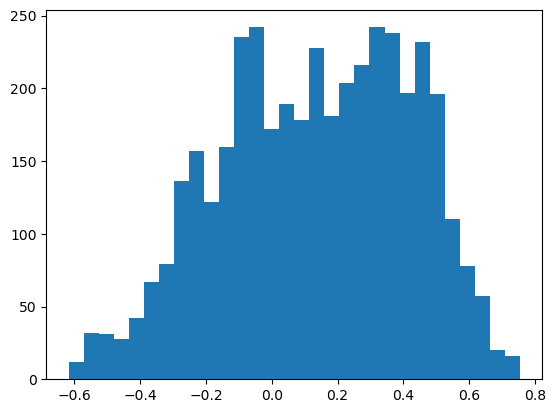

In [595]:
K = 12
bbb = brownian_bridge(1., K, np.random.randn(2**K))
plt.hist(bbb, bins=30)

(array([ 48., 383., 840., 544., 275., 189., 530., 562., 515., 211.]),
 array([-1.42740992, -1.23298726, -1.03856459, -0.84414192, -0.64971925,
        -0.45529659, -0.26087392, -0.06645125,  0.12797142,  0.32239408,
         0.51681675]),
 <BarContainer object of 10 artists>)

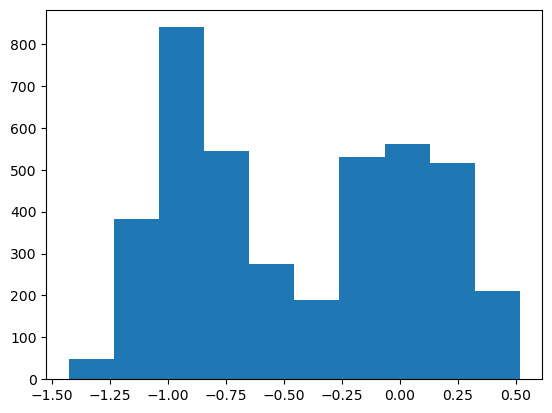

(array([  4.,   6.,  13.,   7.,  21.,  46.,  36.,  33.,  69., 105., 133.,
        171., 151., 182., 148., 161., 140., 136., 121., 139., 155., 133.,
        146., 160., 161., 129., 144.,  92.,  82.,  62.,  58.,  43.,  36.,
         20.,   2.,   7.,  27.,  43.,  52.,  86.,  90., 126., 106.,  79.,
         76.,  85.,  32.,  18.,  12.,  13.]),
 array([-0.90410594, -0.86332934, -0.82255273, -0.78177613, -0.74099953,
        -0.70022292, -0.65944632, -0.61866971, -0.57789311, -0.5371165 ,
        -0.4963399 , -0.4555633 , -0.41478669, -0.37401009, -0.33323348,
        -0.29245688, -0.25168028, -0.21090367, -0.17012707, -0.12935046,
        -0.08857386, -0.04779725, -0.00702065,  0.03375595,  0.07453256,
         0.11530916,  0.15608577,  0.19686237,  0.23763898,  0.27841558,
         0.31919218,  0.35996879,  0.40074539,  0.441522  ,  0.4822986 ,
         0.5230752 ,  0.56385181,  0.60462841,  0.64540502,  0.68618162,
         0.72695823,  0.76773483,  0.80851143,  0.84928804,  0.89006464,
 

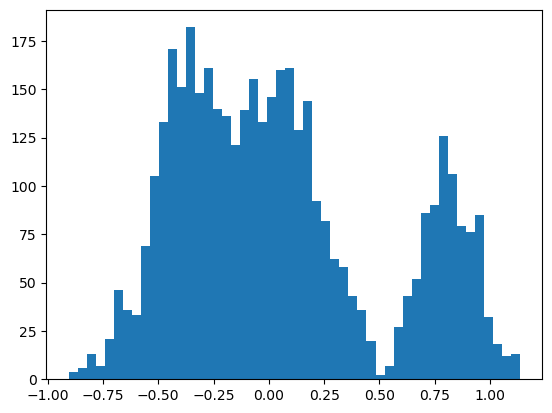

In [577]:
T = 1
K = 12
N = 2**K
Z = np.random.standard_normal()
W = np.zeros(N+1)
W[N] = Z * np.sqrt(T)
h = N
dt = T / N

for k in range(1, K+1):
    h = h / 2
    for j in range(1, 2**(k-1)+1):
        Z = np.random.standard_normal()
        W[int((2*j-1)*h)] = 0.5*(W[int(2*(j-1)*h)] + W[int(2*j*h)]) + Z * np.sqrt(h*dt)

plt.hist(W, bins=50)

In [ ]:
def browbr(B, N, T):

    W = np.zeros(N+1)
    dt = T / N
    W[N] = B[N-1] * np.sqrt(T)

    def browbr_recur(B, dt, i, k):
        if i == k:
            return
        
        j = int((k - i)/2)
        gamma_t = 

    browbr_recur(B, dt, 0, N)

    return W

In [555]:
def RNG(I):  
    return np.random.standard_normal (I)  
    if AP == True :  
        ran = np.random.standard_normal (I/2)  
        ran = np.concatenate (( ran ,- ran ))  
    else :  
        ran = np.random.standard_normal (I)  
    if MM == True :  
        ran =ran - np.mean ( ran)  
        ran = ran / np.std ( ran )  
    return ran  

def Bridge(x,depth,depthmax,I,sigma):  
    if depth==depthmax:  
        return x  
    xmid=np.average(x,0)+0.5*RNG(I)*np.sqrt(sigma/(2**(depth-1)))  
    y=Bridge([x[0][:],xmid[:]],depth+1,depthmax,I,sigma)  
    z=Bridge([xmid[:],x[-1][:]],depth+1,depthmax,I,sigma)  
    x=np.concatenate((y[:-1][:],z[:][:]))  
    return x  

In [571]:
np.random.normal()

-1.476674463852609

In [557]:
ran=np.asarray(RNG(NP))*sigma*np.sqrt(T)  

NameError: name 'NP' is not defined

In [556]:
Bridge([100,150], 10, 100, 1, 0.02)

TypeError: 'int' object is not subscriptable

In [49]:
Bridge()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## References
- [Investopedia - Monte Carlo](https://www.investopedia.com/articles/07/montecarlo.asp)
- HILPISCH, Yves. **Python for Finance: Mastering Data-driven Finance**. 2. ed. O'Reilly Media, 2019.
- Galanti & Jung: "Low-Discrepancy Sequences: Monte Carlo Simulation of Option Prices", Journal of Derivatives, Fall 1997, pp.63-83.

(array([  5.,   1.,  10.,  32.,  51.,  88., 145., 207., 313., 440., 556.,
        731., 790., 913., 915., 918., 842., 747., 649., 534., 385., 270.,
        187., 102.,  87.,  42.,  20.,  11.,   3.,   6.]),
 array([-0.06955349, -0.064852  , -0.06015051, -0.05544902, -0.05074753,
        -0.04604605, -0.04134456, -0.03664307, -0.03194158, -0.02724009,
        -0.0225386 , -0.01783712, -0.01313563, -0.00843414, -0.00373265,
         0.00096884,  0.00567033,  0.01037182,  0.0150733 ,  0.01977479,
         0.02447628,  0.02917777,  0.03387926,  0.03858075,  0.04328223,
         0.04798372,  0.05268521,  0.0573867 ,  0.06208819,  0.06678968,
         0.07149116]),
 <BarContainer object of 30 artists>)

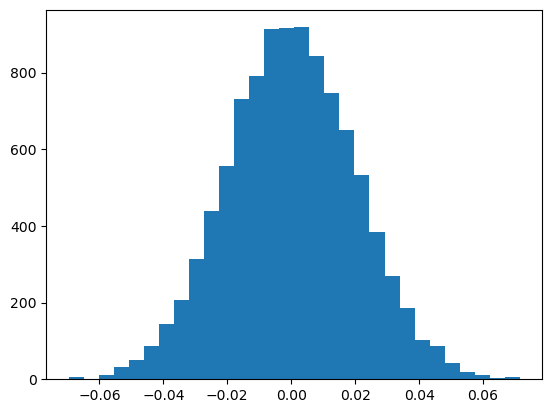

In [622]:
AP = False
MM = False

def RNG(I):  
    if AP == True :  
        ran = np.random.standard_normal (I/2)  
        ran = np.concatenate (( ran ,- ran ))  
    else :  
        ran = np.random.standard_normal (I)  
    if MM == True :  
        ran =ran - np.mean ( ran)  
        ran = ran / np.std ( ran )  
    return ran  
        
#we create path with the brownian bridge  
def Bridge(x,depth,depthmax,I,sigma):  
    if depth==depthmax:  
        return x  
    xmid=np.average(x,0)+0.5*RNG(I)*np.sqrt(sigma/(2**(depth-1)))  
    y=Bridge([x[0][:],xmid[:]],depth+1,depthmax,I,sigma)  
    z=Bridge([xmid[:],x[-1][:]],depth+1,depthmax,I,sigma)  
    x=np.concatenate((y[:-1][:],z[:][:]))  
    return x  


sigma = 0.02
depth = 1
ran=np.asarray(RNG(10000))*sigma*np.sqrt(T)
ranBB=(np.concatenate(([ran-ran],[ran])))  
ranBB
ranBB=Bridge(ranBB,1,depth+1,ranBB.shape[1],sigma*sigma*T)  
plt.hist(ranBB[2], bins=30)

In [611]:
len(ranBB[0])

100

In [606]:
def MC3(option,params):  
      
    #antithetic  
    AP=params.AP  
    #moment matching  
    MM=params.MM  
      
    #number of time steps and of paths  
      
    NTS=params.NTS  
    NP=params.NP  
    depth=params.depth  
    [S0,K,sigma,T,r2,divi,american]=[float(option.S0),float(option.K),option.sigma,float(option.T),option.r,option.divi,option.american]  
      
    #we process the terminal random variables  
    def RNG(I):  
        if AP == True :  
            ran = np.random.standard_normal (I/2)  
            ran = np.concatenate (( ran ,- ran ))  
        else :  
            ran = np.random.standard_normal (I)  
        if MM == True :  
            ran =ran - np.mean ( ran)  
            ran = ran / np.std ( ran )  
        return ran  
          
    #we create path with the brownian bridge  
    def Bridge(x,depth,depthmax,I,sigma):  
        if depth==depthmax:  
            return x  
        xmid=np.average(x,0)+0.5*RNG(I)*np.sqrt(sigma/(2**(depth-1)))  
        y=Bridge([x[0][:],xmid[:]],depth+1,depthmax,I,sigma)  
        z=Bridge([xmid[:],x[-1][:]],depth+1,depthmax,I,sigma)  
        x=np.concatenate((y[:-1][:],z[:][:]))  
        return x  
          
    dt=float(T)/NTS  
    np.random.seed  
      
    dividends,dividendsStep=preparedivs(divi,T,dt)  
    r,rArray,rateChangeStep,DFArray=preparerates(r2,T,dt,NTS)  
      
    #get present value of the dividend   
    #this is done to apply the Hull approximation for european options  
    pvdividends=0      
    if np.size(dividends)>0:  
        for index,dv in enumerate(list(dividends[1])):  
            pvdividends=pvdividends+dv*DFArray[np.int_(dividendsStep[index])]  
     
       
    #we directly compute the final value of the brownian motion  
    ran=np.asarray(RNG(NP))*sigma*np.sqrt(T)  
      
    #if we get the proper rate, we can directly get the european value  
    df=np.prod(DFArray[1:NTS])  
    rate=-np.log(df)/T  
      
      
    # generate stock price paths  
    SEuro= np.zeros ((NP),'d') # index level matrix  
    # generate stock price paths  
    S= np.zeros ((NTS,NP),'d') # index level matrix  
    S[0 ,:]= S0 # initial values  
    rr=r[1][1]  
    #we apply the usuall hull method  
    SEuro[:]=(S0-pvdividends)*np.exp((rate-0.5*sigma **2)* T+ ran[:])  
      
    if american==True:  
        #we then proceed to generate intermediate values  
        ranBB=(np.concatenate(([ran-ran],[ran])))  
        ranBB=Bridge(ranBB,1,depth+1,ranBB.shape[1],sigma*sigma*T)  
        incBB=ranBB[1:][:]-ranBB[:-1][:]  
          
        for t in range (1,NTS): # loop over the days  
            if (t in rateChangeStep[:]):  
                rr= (r[1][np.nonzero(rateChangeStep==(t))[0]+1])  
            S[t ,:]= S[t-1 ,:]* np.exp ((rr-0.5*sigma **2)* dt+incBB[t][:])  
      
            if (t in dividendsStep):  
                div=dividends[1][np.nonzero(dividendsStep==(t))[0]]    
                S[t,:]=np.maximum(S[t,:]-div,0)  
  
               
        #apply LMS method  
        VC=np.maximum(S-K,0)  
        VP=np.maximum(K-S,0)  
          
        hC=VC  
        hP=VP  
        deg=2  
          
        for t in range(NTS-2,-1,-1):  
              
            df=DFArray[t]  
              
            #get the ITM call  
            dummy=np.greater(hC[t,:],0)  
            relevant=np.nonzero(dummy)  
            relevantS=np.compress(dummy,S[t,:])  
            p=len(relevantS)  
          
            #if any  
            if p==0:  
                contvalues=np.zeros((NP))  
            else:  
                relevantV=np.compress(dummy,VC[t+1,:]*df)  
                #rg is an approximation of the call price as a function of the stock                  
                #only in the ITM region  
                #to fit that function we discount call prices from thenext time step (we go backward in time)  
                rg=np.polyfit(relevantS[:],relevantV[:],deg)                
                contvalues=np.polyval(rg,relevantS[:])  
                  
            #for each call we check if exercise now is higher than approximate value of keeping it      
            erg=np.zeros((NP))  
            np.put(erg,relevant,contvalues)  
            #V2=VC[t+1,:]*df  
            VC[t,:]=np.where(hC[t,:]>erg,hC[t,:],VC[t+1,:]*df)  
            #this displays the %age of path exercising at this step              
            #print t,sum(np.greater(V2,VC[t,:]))/float(NP)  
               
            #then do the same for the puts  
            dummy=np.greater(hP[t,:],0)  
            relevant=np.nonzero(dummy)  
            relevantS=np.compress(dummy,S[t,:])  
            p=len(relevantS)  
              
     
            #if any  
            if p==0:  
                contvalues=np.zeros((NP))  
            else:  
                relevantV=np.compress(dummy,VP[t+1,:]*df)  
                #rg is an approximation of the put price as a function of the stock                  
                #only in the ITM region  
                #to fit that function we discount put prices from thenext time step (we go backward in time)  
                rg=np.polyfit(relevantS[:],relevantV[:],deg)                
                contvalues=np.polyval(rg,relevantS[:])  
                  
            #for each put we check if exercise now is higher than approximate value of keeping it      
                          
            erg=np.zeros((NP))  
            np.put(erg,relevant,contvalues)  
            #V2=VP[t+1,:]*df  
            VP[t,:]=np.where(hP[t,:]>erg,hP[t,:],VP[t+1,:]*df)  
            #Use this to display the % of path exercising at this step  
            #print t,sum(np.greater(V2,VP[t,:]))/float(NP)  
         
        option.call.price=sum(VC[0,:])/NP  
        option.put.price=sum(VP[0,:])/NP  
    else:     
        df=np.prod(DFArray[1:NTS])  
        VC=np.maximum(SEuro[:]-K,0)  
        option.call.price=df*sum(VC)/NP  
        VP=np.maximum(-SEuro[:]+K,0)  
        option.put.price=df*sum(VP)/NP  
    return S

(array([  1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   3.,   4.,   4.,   1.,   5.,   4.,   7.,   7.,
          9.,   8.,  18.,  16.,  24.,  29.,  40.,  36.,  42.,  56.,  42.,
         70.,  76.,  88., 103., 125., 107., 140., 155., 182., 192., 221.,
        214., 216., 258., 274., 264., 317., 294., 293., 288., 323., 335.,
        305., 306., 284., 312., 338., 278., 260., 285., 265., 239., 236.,
        223., 218., 168., 159., 178., 122., 129., 117., 101.,  89.,  66.,
         61.,  53.,  52.,  54.,  34.,  41.,  29.,  17.,  19.,  19.,   5.,
          8.,   8.,   6.,   6.,   4.,   5.,   1.,   3.,   1.,   0.,   0.,
          3.]),
 array([-4.43490487, -4.35465833, -4.2744118 , -4.19416526, -4.11391872,
        -4.03367218, -3.95342564, -3.8731791 , -3.79293256, -3.71268603,
        -3.63243949, -3.55219295, -3.47194641, -3.39169987, -3.31145333,
        -3.23120679, -3.15096025, -3.07071372, -2.99046718, -2.91022064,
        -2.8299741 , -2.74

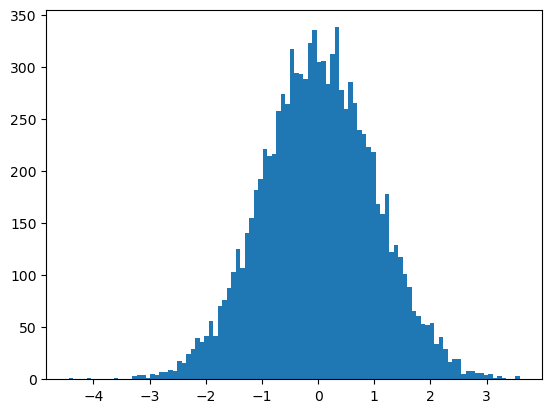

In [588]:
plt.hist(np.random.randn(10000), bins=100)